## Setup

In [1]:
import os
from dotenv import load_dotenv
from src import util

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import optuna
import joblib

C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V2.parquet")
target_column = "target_class_in_24h"

df_model_input = util.create_df_model_input(slided_df_path, target_column, "xl_", '10min', 'last')

In [3]:
specialist_training_pool = df_model_input[df_model_input[target_column] > 3].copy()

In [4]:
train_pct = 0.7
val_pct = (1-train_pct)/2
test_pct = (1-train_pct)/2

specialist_data = util.prepare_data(specialist_training_pool, target_column, lambda lb: 1 if lb == 5 else 0, train_pct, val_pct)

## Training and Parameter Tuning

In [101]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,

        'device': 'cuda',

        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 1.0, 20.0, log=True),

        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model_ = xgb.XGBClassifier(**params)

    model_.fit(
        specialist_data['x']['train'],
        specialist_data['y']['train'],
        eval_set=[(specialist_data['x']['val'], specialist_data['y']['val'])],
        verbose=False
    )

    y_pred_val = model_.predict(specialist_data['x']['val'])

    recall_x = recall_score(specialist_data['y']['val'], y_pred_val, pos_label=1)
    recall_m = recall_score(specialist_data['y']['val'], y_pred_val, pos_label=0)
    # w = 1.5
    # score = (w * recall_x) + (1 * recall_m)

    recall_x_threshold = 0.9
    if recall_x < recall_x_threshold:
        score = recall_x - 10
    else:
        score = recall_m

    return score

In [102]:
study = optuna.create_study(direction='maximize')
print("\nIniciando o tuning...")
study.optimize(objective, n_trials=500)

print("\nBusca concluída!")
print(f"Melhor valor (macro f1-score): {study.best_value:.4f}")
print("Melhores parâmetros encontrados:")
print(study.best_params)

[I 2025-11-08 21:27:18,406] A new study created in memory with name: no-name-25592b4b-9546-47b7-8086-acb7c4432b10



Iniciando o tuning...


[I 2025-11-08 21:27:21,157] Trial 0 finished with value: -9.457769762548843 and parameters: {'scale_pos_weight': 19.95986454569866, 'max_depth': 3, 'learning_rate': 0.0210912893167086, 'subsample': 0.9014008961765195, 'colsample_bytree': 0.9570272949283566, 'gamma': 2.3066834589674006, 'min_child_weight': 10}. Best is trial 0 with value: -9.457769762548843.
[I 2025-11-08 21:27:21,862] Trial 1 finished with value: -9.871355575593627 and parameters: {'scale_pos_weight': 10.587537665531723, 'max_depth': 8, 'learning_rate': 0.2529333203618952, 'subsample': 0.6703426997755569, 'colsample_bytree': 0.9542745538882447, 'gamma': 3.6962188274882095, 'min_child_weight': 1}. Best is trial 0 with value: -9.457769762548843.
[I 2025-11-08 21:27:22,290] Trial 2 finished with value: -10.0 and parameters: {'scale_pos_weight': 1.731034165678507, 'max_depth': 5, 'learning_rate': 0.0706969566505099, 'subsample': 0.8175278469335443, 'colsample_bytree': 0.9258093237233547, 'gamma': 2.207254985445367, 'min_ch


Busca concluída!
Melhor valor (macro f1-score): -9.2083
Melhores parâmetros encontrados:
{'scale_pos_weight': 19.803013940137475, 'max_depth': 3, 'learning_rate': 0.010062675681971717, 'subsample': 0.6079571416597074, 'colsample_bytree': 0.7068270761167291, 'gamma': 4.8984172733341556, 'min_child_weight': 5}


In [103]:
specialist_params = study.best_params

specialist_params.update({
    'n_estimators': 10000,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 1502,
    'n_jobs': -1,
    'early_stopping_rounds': 50
})

In [104]:
print(specialist_params)

{'scale_pos_weight': 19.803013940137475, 'max_depth': 3, 'learning_rate': 0.010062675681971717, 'subsample': 0.6079571416597074, 'colsample_bytree': 0.7068270761167291, 'gamma': 4.8984172733341556, 'min_child_weight': 5, 'n_estimators': 10000, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 1502, 'n_jobs': -1, 'early_stopping_rounds': 50}


In [105]:
specialist_model = xgb.XGBClassifier(**specialist_params)

print("\nIniciando o treinamento...")
specialist_model.fit(
    specialist_data['x']['train'],
    specialist_data['y']['train'],
    eval_set=[(specialist_data['x']['val'], specialist_data['y']['val'])],
    verbose=100
)
print("Treinamento concluído.")


Iniciando o treinamento...
[0]	validation_0-logloss:1.14426
[100]	validation_0-logloss:1.04652
[200]	validation_0-logloss:1.01109
[300]	validation_0-logloss:0.98938
[400]	validation_0-logloss:0.97648
[500]	validation_0-logloss:0.96492
[600]	validation_0-logloss:0.95375
[700]	validation_0-logloss:0.92966
[800]	validation_0-logloss:0.91219
[900]	validation_0-logloss:0.89645
[1000]	validation_0-logloss:0.88784
[1100]	validation_0-logloss:0.87385
[1200]	validation_0-logloss:0.86445
[1300]	validation_0-logloss:0.85167
[1400]	validation_0-logloss:0.83577
[1500]	validation_0-logloss:0.82726
[1524]	validation_0-logloss:0.82722
Treinamento concluído.


## Results

--- Relatório de Classificação (Conjunto de Teste) ---

              precision    recall  f1-score   support

       M (0)       0.87      0.56      0.68     34012
       X (1)       0.19      0.55      0.28      6240

    accuracy                           0.56     40252
   macro avg       0.53      0.56      0.48     40252
weighted avg       0.77      0.56      0.62     40252


--- Matriz de Confusão ---


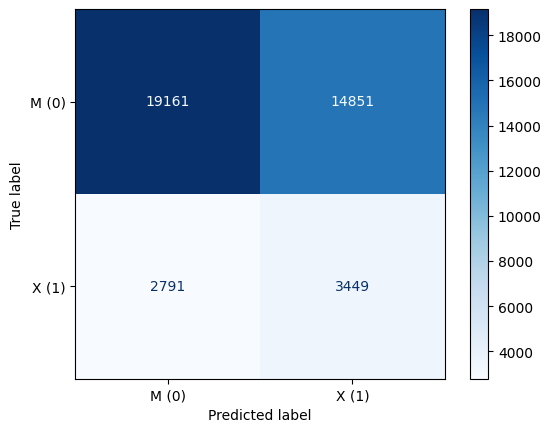

In [106]:
specialist_y_pred = specialist_model.predict(specialist_data['x']['test'])

print("--- Relatório de Classificação (Conjunto de Teste) ---\n")
print(classification_report(specialist_data['y']['test'], specialist_y_pred, target_names=['M (0)', 'X (1)']))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(specialist_data['y']['test'], specialist_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['M (0)', 'X (1)'])
disp.plot(cmap='Blues')
plt.show()

### Evaluating Tradeoff Cost

In [ ]:
specialist_y_multiclass = df_model_input[target_column]

val_end = int(len(specialist_data['x']['all']) * (val_pct + train_pct))
specialist_y_multi_truth = specialist_y_multiclass.iloc[val_end:]

In [ ]:
df_analysis = pd.DataFrame(index=specialist_data['y']['test'].index)
df_analysis['binary_truth'] = specialist_data['y']['test']
df_analysis['binary_pred'] = specialist_y_pred
df_analysis['multiclass_truth'] = specialist_y_multi_truth

is_false_negative = (df_analysis['binary_truth'] == 1) & (df_analysis['binary_pred'] == 0)
df_false_negatives = df_analysis[is_false_negative]
print(f"Número total de Falsos Negativos encontrados: {len(df_false_negatives)}")

In [ ]:
df_false_negatives

### Exporting Model

In [109]:
model_save_path = r'../../models/specialist_model_v1.joblib'
joblib.dump(specialist_model, model_save_path)
print(f"Modelo salvo em {model_save_path}")

Modelo salvo em ../../models/specialist_model_v1.joblib
